In [ ]:
!pip install torch transformers torchvision requests pandas pillow datasets
!pip install faiss-cpu
!pip install chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install kagglehub kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

print("Path to dataset files:", path)

100%|██████████| 13.2G/13.2G [02:36<00:00, 90.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import faiss
from transformers import FlavaProcessor, FlavaModel
reports_df = pd.read_csv("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/indiana_reports.csv")
projections_df = pd.read_csv("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/indiana_projections.csv")
df = reports_df.merge(projections_df, on="uid")
print("Dataset Overview:")
print(df.head())
model_name = "facebook/flava-full"
processor = FlavaProcessor.from_pretrained(model_name)
model = FlavaModel.from_pretrained(model_name)
model.eval()
def extract_multimodal_features(image_path, text):
    """Extract consistent combined multimodal features from FLAVA."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        features = outputs.multimodal_embeddings[:, 0, :].squeeze(0).numpy()
    return features
sample_image_path = os.path.join("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized", df["filename"].iloc[0])
sample_text = df["findings"].iloc[0]
sample_features = extract_multimodal_features(sample_image_path, sample_text)
dim = sample_features.shape[0]
index = faiss.IndexFlatL2(dim)
report_embeddings = []
case_texts = []
processed_count = 0
max_images = 50
for i, row in df.iterrows():
    if processed_count >= max_images:
        break
    image_path = os.path.join("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized", row["filename"])
    case_text = row["findings"]

    if pd.isnull(case_text) or not isinstance(case_text, str) or not os.path.exists(image_path):
        continue

    if "impressions" in df.columns and pd.notna(row["impressions"]):
        case_text += " " + row["impressions"]
    combined_features = extract_multimodal_features(image_path, case_text)
    if combined_features.shape[0] == dim:
        report_embeddings.append(combined_features)
        case_texts.append(case_text)
        processed_count += 1
    else:
        print(f"Skipping entry with mismatched dimensions: {combined_features.shape}")
if report_embeddings:
    index.add(np.vstack(report_embeddings).astype(np.float32))
    print(f"FAISS index built with {len(report_embeddings)} embeddings.")
else:
    print("No valid embeddings found to build the FAISS index.")
def retrieve_similar_cases(query_text, query_image_path, top_k=3):
    """Retrieve similar cases from the RAG system."""
    query_features = extract_multimodal_features(query_image_path, query_text)

    if query_features.shape[0] == dim:
        distances, indices = index.search(query_features.reshape(1, -1), top_k)
        return [case_texts[i] for i in indices[0] if i < len(case_texts)]
    else:
        print("Query features dimension mismatch.")
        return []
query_text = "Patient has pneumonia with fluid accumulation."
query_image_path = os.path.join("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized", df["filename"].iloc[1])
retrieved_cases = retrieve_similar_cases(query_text, query_image_path)
print("\nRetrieved Similar Cases:")
for case in retrieved_cases:
    print("-", case)

Dataset Overview:
   uid                                               MeSH  \
0    1                                             normal   
1    1                                             normal   
2    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
4    3                                             normal   

                        Problems                                image  \
0                         normal            Xray Chest PA and Lateral   
1                         normal            Xray Chest PA and Lateral   
2  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
3  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
4                         normal            Xray Chest PA and Lateral   

                                          indication comparison  \
0                                   Positive TB test      None.   
1                                   Positi

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


FAISS index built with 50 embeddings.

Retrieved Similar Cases:
- The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
- The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
- Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings.


In [ ]:
query_text = "Patient has pneumonia with fluid accumulation."
query_image_path = os.path.join("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized", df["filename"].iloc[1])
retrieved_cases = retrieve_similar_cases(query_text, query_image_path)
print("\nRetrieved Similar Cases:")
for case in retrieved_cases:
    print("-", case)


Retrieved Similar Cases:
- The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
- The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
- Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings.


In [ ]:
query_text = "Patient has an enlarged heart with abnormal heart shadow in X-ray."
query_image_path = os.path.join("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized", df["filename"].iloc[1])
retrieved_cases = retrieve_similar_cases(query_text, query_image_path)
print("\nRetrieved Similar Cases:")
for case in retrieved_cases:
    print("-", case)


Retrieved Similar Cases:
- The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
- The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.
- Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings.


In [ ]:
query_text = ""
query_image_path = os.path.join("/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized", df["filename"].iloc[1])
retrieved_cases = retrieve_similar_cases(query_text, query_image_path)
print("\nRetrieved Similar Cases:")
for case in retrieved_cases:
    print("-", case)

In [ ]:
import random
import os
import json
import pandas as pd
import base64
import matplotlib.pyplot as plt
from IPython.display import display, HTML


class RoleBasedAccess:
    def __init__(self, df, retrieved_cases):
        self.df = df
        self.retrieved_cases = retrieved_cases
        self.nurse_view = None
        self.doctor_view = None
        self.chief_doctor_view = None

    def get_access(self, patient_id, role):
        num_xrays = random.randint(1, 5)
        num_lab_reports = random.randint(2, 6)

        if role == "nurse":
            patient_record = self.df.sample(1).iloc[0]
            findings = patient_record["findings"]
            impression = (
                patient_record["impression"]
                if pd.notna(patient_record["impression"])
                else "No impression provided."
            )
            prescriptions = self.get_prescriptions(findings, impression)

            self.nurse_view = {
                "Patient ID": patient_id,
                "X-rays": f"{num_xrays} x-ray(s)",
                "Lab Reports": f"{num_lab_reports} lab report(s)",
                "Findings": findings,
                "Impression": impression,
                "Prescriptions": prescriptions,
            }
            return self.nurse_view

        elif role == "doctor":
            if not self.retrieved_cases:
                return "No summary reports found."
            self.doctor_view = {"Patient ID": patient_id, "Summaries": self.retrieved_cases}
            return self.doctor_view

        elif role == "chief_doctor":
            patient_records = self.df.sample(2)
            detailed_reports = []

            for _, row in patient_records.iterrows():
                image_path = os.path.join(
                    "/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized",
                    row["filename"],
                )
                if os.path.exists(image_path):
                    detailed_reports.append(
                        {
                            "findings": row["findings"],
                            "impression": row["impression"]
                            if pd.notna(row["impression"])
                            else "No impression provided.",
                            "image_path": image_path,
                        }
                    )

            self.chief_doctor_view = {
                "Patient ID": patient_id,
                "Detailed Reports": [
                    {"Findings": report["findings"], "Impression": report["impression"]}
                    for report in detailed_reports
                ],
            }

            self.generate_html_output(
                self.nurse_view, self.doctor_view, self.chief_doctor_view, detailed_reports
            )
            return self.chief_doctor_view

        else:
            return "Invalid role. Access denied."

    def get_prescriptions(self, findings, impression):
        condition_prescriptions = {
            "pneumonia": [
                "Azithromycin 500mg - Once daily for 5 days",
                "Paracetamol 500mg - If fever persists",
            ],
            "bronchitis": [
                "Salbutamol Inhaler - 2 puffs every 6 hours",
                "Prednisolone 5mg - Once daily for 7 days",
            ],
            "pleural effusion": [
                "Furosemide 20mg - Once daily",
                "Oxygen therapy if necessary",
            ],
            "cardiomegaly": [
                "Beta-blockers (Metoprolol 50mg) - Once daily",
                "ACE Inhibitors (Lisinopril 10mg) - Once daily",
            ],
            "tuberculosis": [
                "Rifampicin 600mg - Once daily",
                "Isoniazid 300mg - Once daily",
                "Ethambutol 800mg - Once daily",
            ],
            "asthma": [
                "Salbutamol Inhaler - 2 puffs every 6 hours",
                "Budesonide 200mcg - Twice daily",
            ],
            "normal": ["Vitamin D supplement - Once daily", "Multivitamin - Once daily"],
        }
        prescriptions = ["General antibiotics if needed", "Paracetamol 500mg - If fever or pain persists"]
        for condition, meds in condition_prescriptions.items():
            if condition in findings.lower() or condition in impression.lower():
                prescriptions = meds
                break
        return prescriptions

    def encode_image(self, image_path):
        """Encodes image as base64 to embed it in HTML."""
        try:
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode("utf-8")
        except FileNotFoundError:
            return None

    def generate_html_output(self, nurse_summary, doctor_summary, chief_summary, reports):
        """Generates an HTML report with the summaries and images."""
        html_code = f"""
        <html>
        <head>
            <style>
                body {{
                    font-family: 'Georgia', serif;
                    background-color: #f9f9f9;
                    margin: 0;
                    padding: 0;
                    display: flex;
                    justify-content: center;
                }}
                .container {{
                    width: 80%;
                    max-width: 900px;
                    margin: 20px auto;
                    padding: 20px;
                }}
                .box {{
                    padding: 15px;
                    width: 90%;
                    max-width: 600px;
                    border: 1px solid #ddd;
                    border-radius: 8px;
                    background-color: #fff;
                    margin: 15px auto;
                    box-shadow: 1px 1px 8px rgba(0,0,0,0.1);
                    text-align: left;
                }}
                img {{
                    width: 280px;
                    height: auto;
                    border-radius: 8px;
                    margin-bottom: 12px;
                    display: block;
                    margin-left: auto;
                    margin-right: auto;
                }}
                pre {{
                    white-space: pre-wrap;
                    word-wrap: break-word;
                    background-color: #f4f4f4;
                    padding: 12px;
                    border-radius: 8px;
                    font-size: 14px;
                    color: #333;
                    overflow-x: auto;
                }}
                p {{
                    color: #444;
                    font-size: 14px;
                    margin: 5px 0;
                }}
                h2, h3 {{
                    color: #333;
                    font-size: 20px;
                    margin-top: 20px;
                    text-align: center;
                }}
                h1 {{
                    color: #222;
                    text-align: center;
                    margin-bottom: 20px;
                    font-size: 26px;
                }}
                strong {{
                    font-weight: bold;
                    color: #333;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Patient Summary Report</h1>
                <h2>Nurse View</h2>
                <div class="box"><pre>{json.dumps(nurse_summary, indent=4)}</pre></div>
                <h2>Doctor View</h2>
                <div class="box"><pre>{json.dumps(doctor_summary, indent=4)}</pre></div>
                <h2>Chief Doctor View</h2>
                <div class="box"><pre>{json.dumps(chief_summary, indent=4)}</pre></div>
                <h3>Images</h3>
        """

        for report in reports:
            image_path = report["image_path"]
            findings = report["findings"]
            impression = report["impression"]
            encoded_image = self.encode_image(image_path) if os.path.exists(image_path) else None

            if encoded_image:
                html_code += f"""
                <div class="box">
                    <img src="data:image/png;base64,{encoded_image}" alt="X-ray Image">
                    <p><strong>Findings:</strong> {findings}</p>
                    <p><strong>Impression:</strong> {impression}</p>
                </div>
                """
            else:
                html_code += f"""
                <div class="box">
                    <p><strong>Findings:</strong> {findings}</p>
                    <p><strong>Impression:</strong> {impression}</p>
                    <p><strong>Image not found:</strong> {image_path}</p>
                </div>
                """

        html_code += """
            </div>
        </body>
        </html>
        """

        with open("report.html", "w") as f:
            f.write(html_code)
        print("Report successfully generated: 'report.html'.")


# Dummy patient ID
sample_patient_id = f"PAT-{random.randint(1000, 9999)}"

# Example Usage:
# Replace `df` and `retrieved_cases` with the actual data before running.
rbac = RoleBasedAccess(df, retrieved_cases)

nurse_view = rbac.get_access(sample_patient_id, "nurse")
doctor_view = rbac.get_access(sample_patient_id, "doctor")
chief_doctor_view = rbac.get_access(sample_patient_id, "chief_doctor")

# Pretty print the output
print("\nNurse View:\n", json.dumps(nurse_view, indent=4))
print("\nDoctor View:\n", json.dumps(doctor_view, indent=4))
print("\nChief Doctor View:\n", json.dumps(chief_doctor_view, indent=4))


Report successfully generated: 'report.html'.

Nurse View:
 {
    "Patient ID": "PAT-8413",
    "X-rays": "2 x-ray(s)",
    "Lab Reports": "2 lab report(s)",
    "Findings": "The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.",
    "Impression": "No active disease.",
    "Prescriptions": [
        "Vitamin D supplement - Once daily",
        "Multivitamin - Once daily"
    ]
}

Doctor View:
 {
    "Patient ID": "PAT-8413",
    "Summaries": [
        "The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.",
        "The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.",
        "Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings."
    ]
}


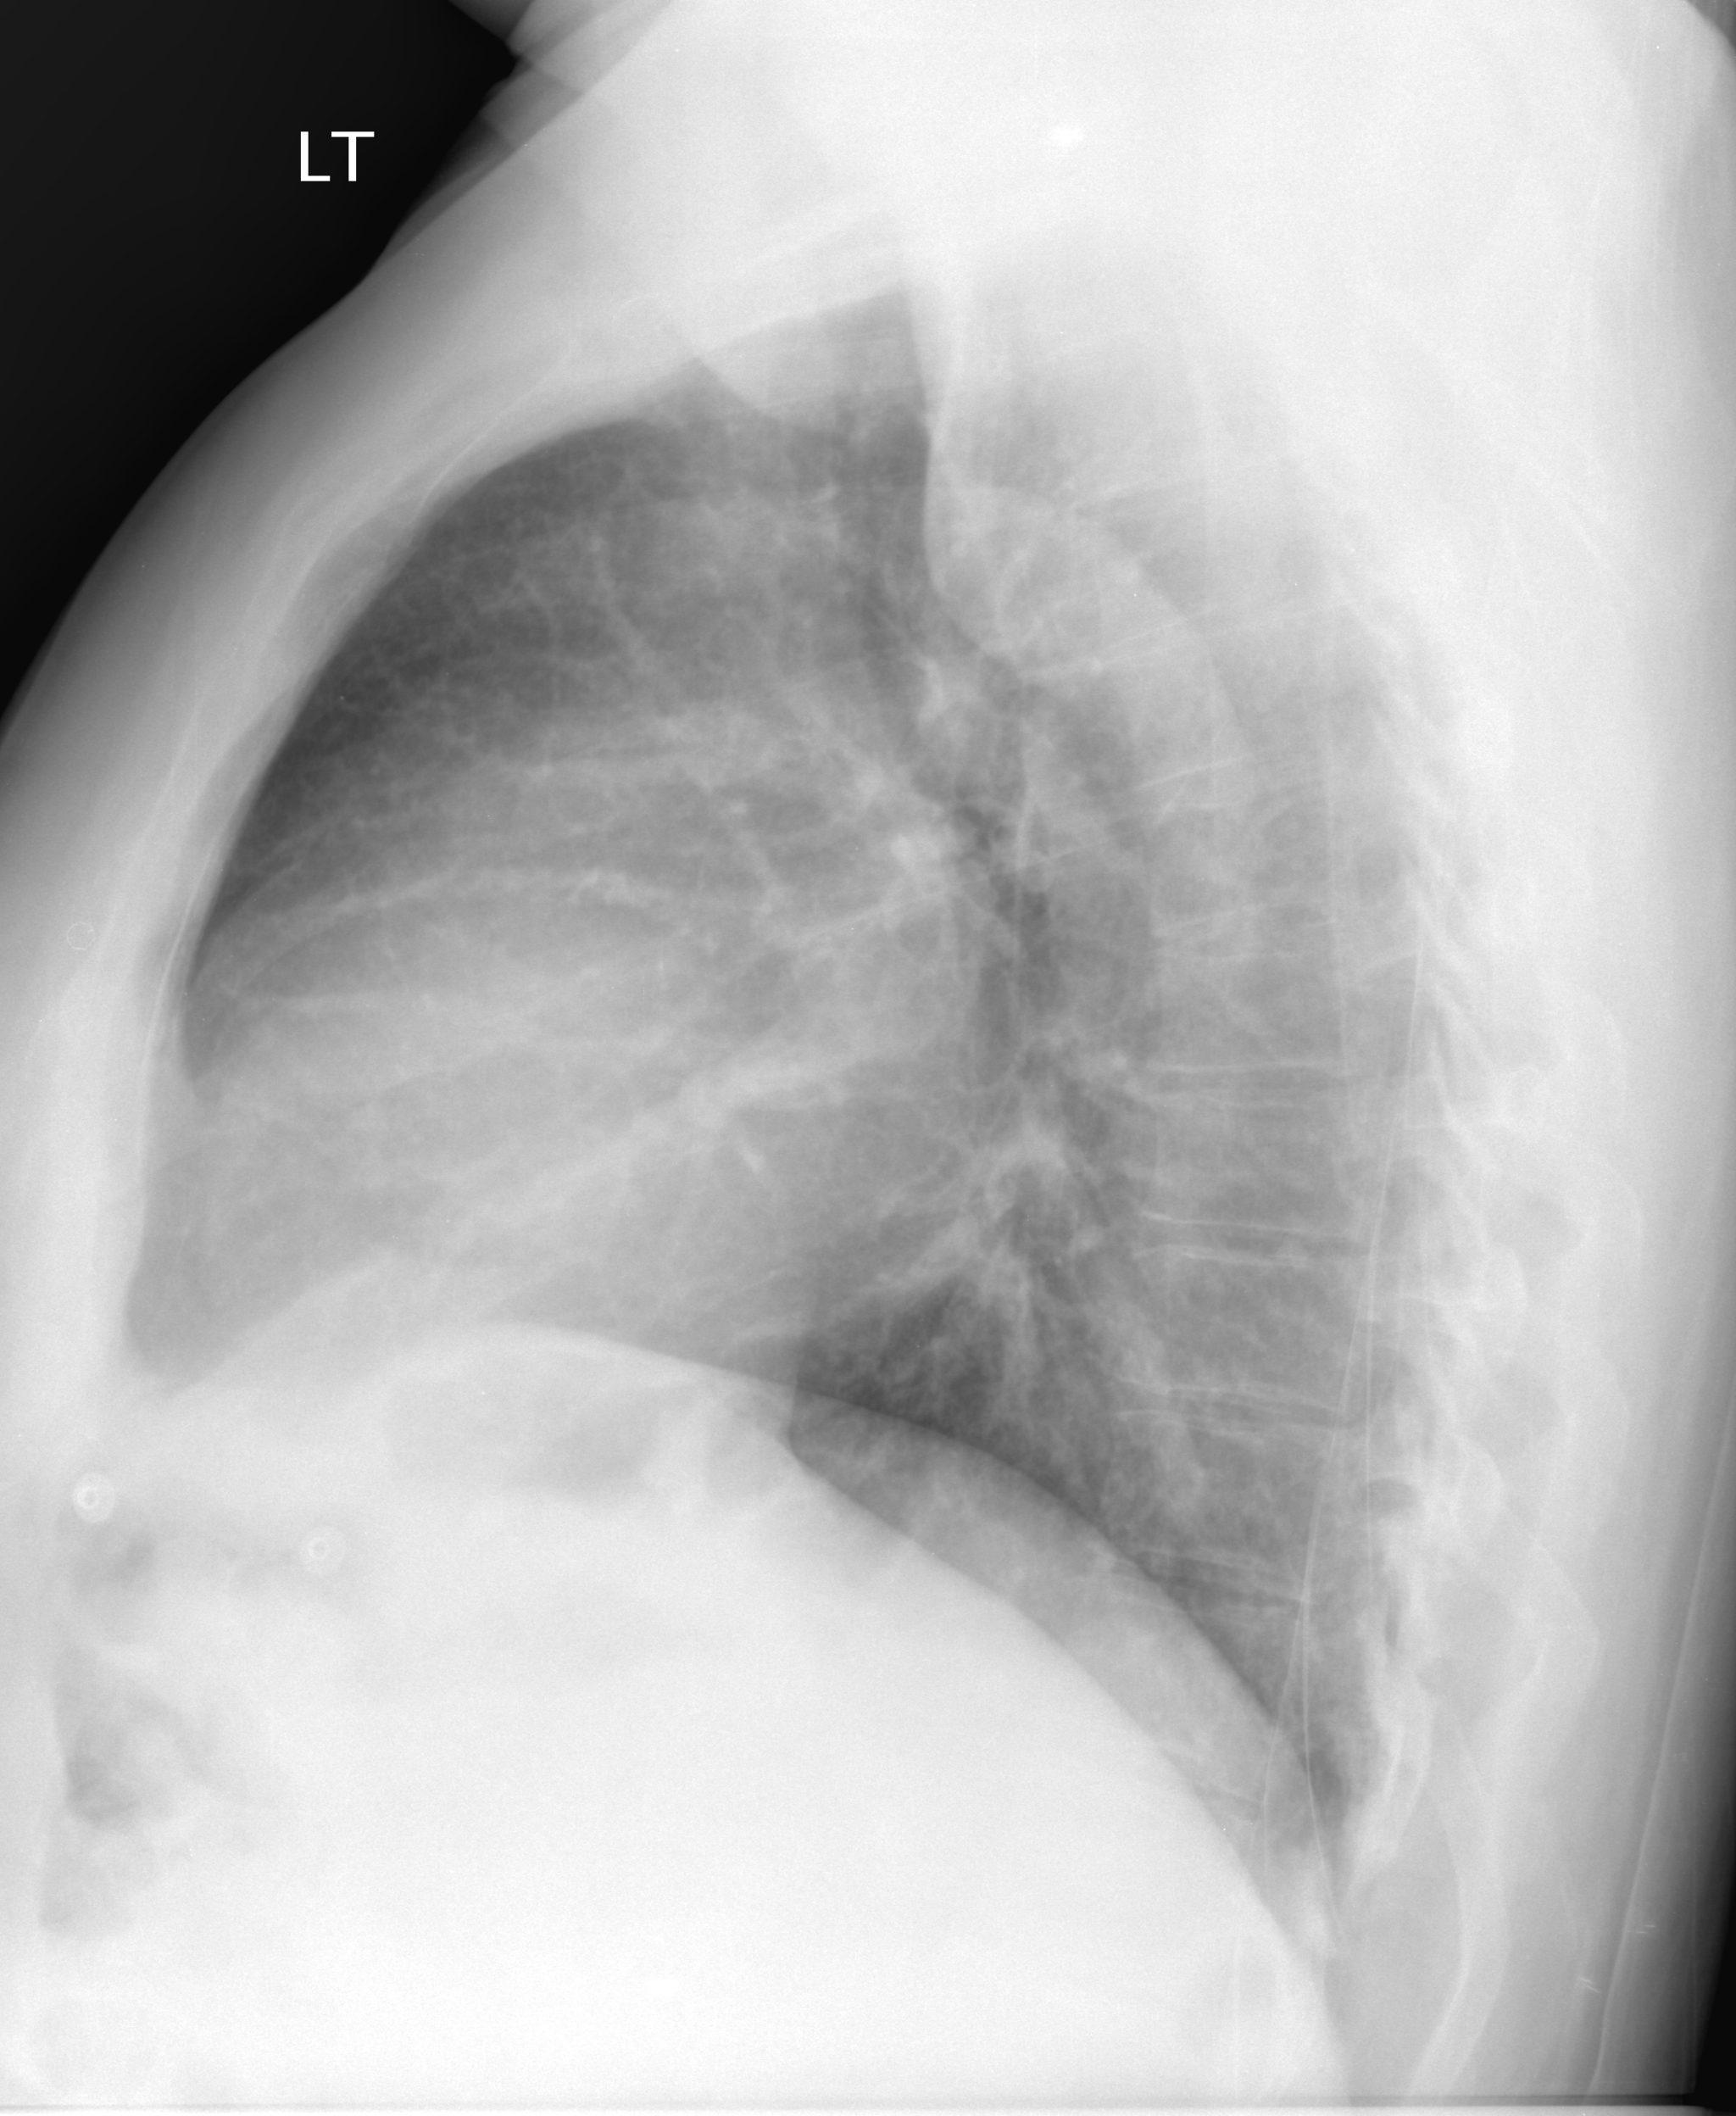
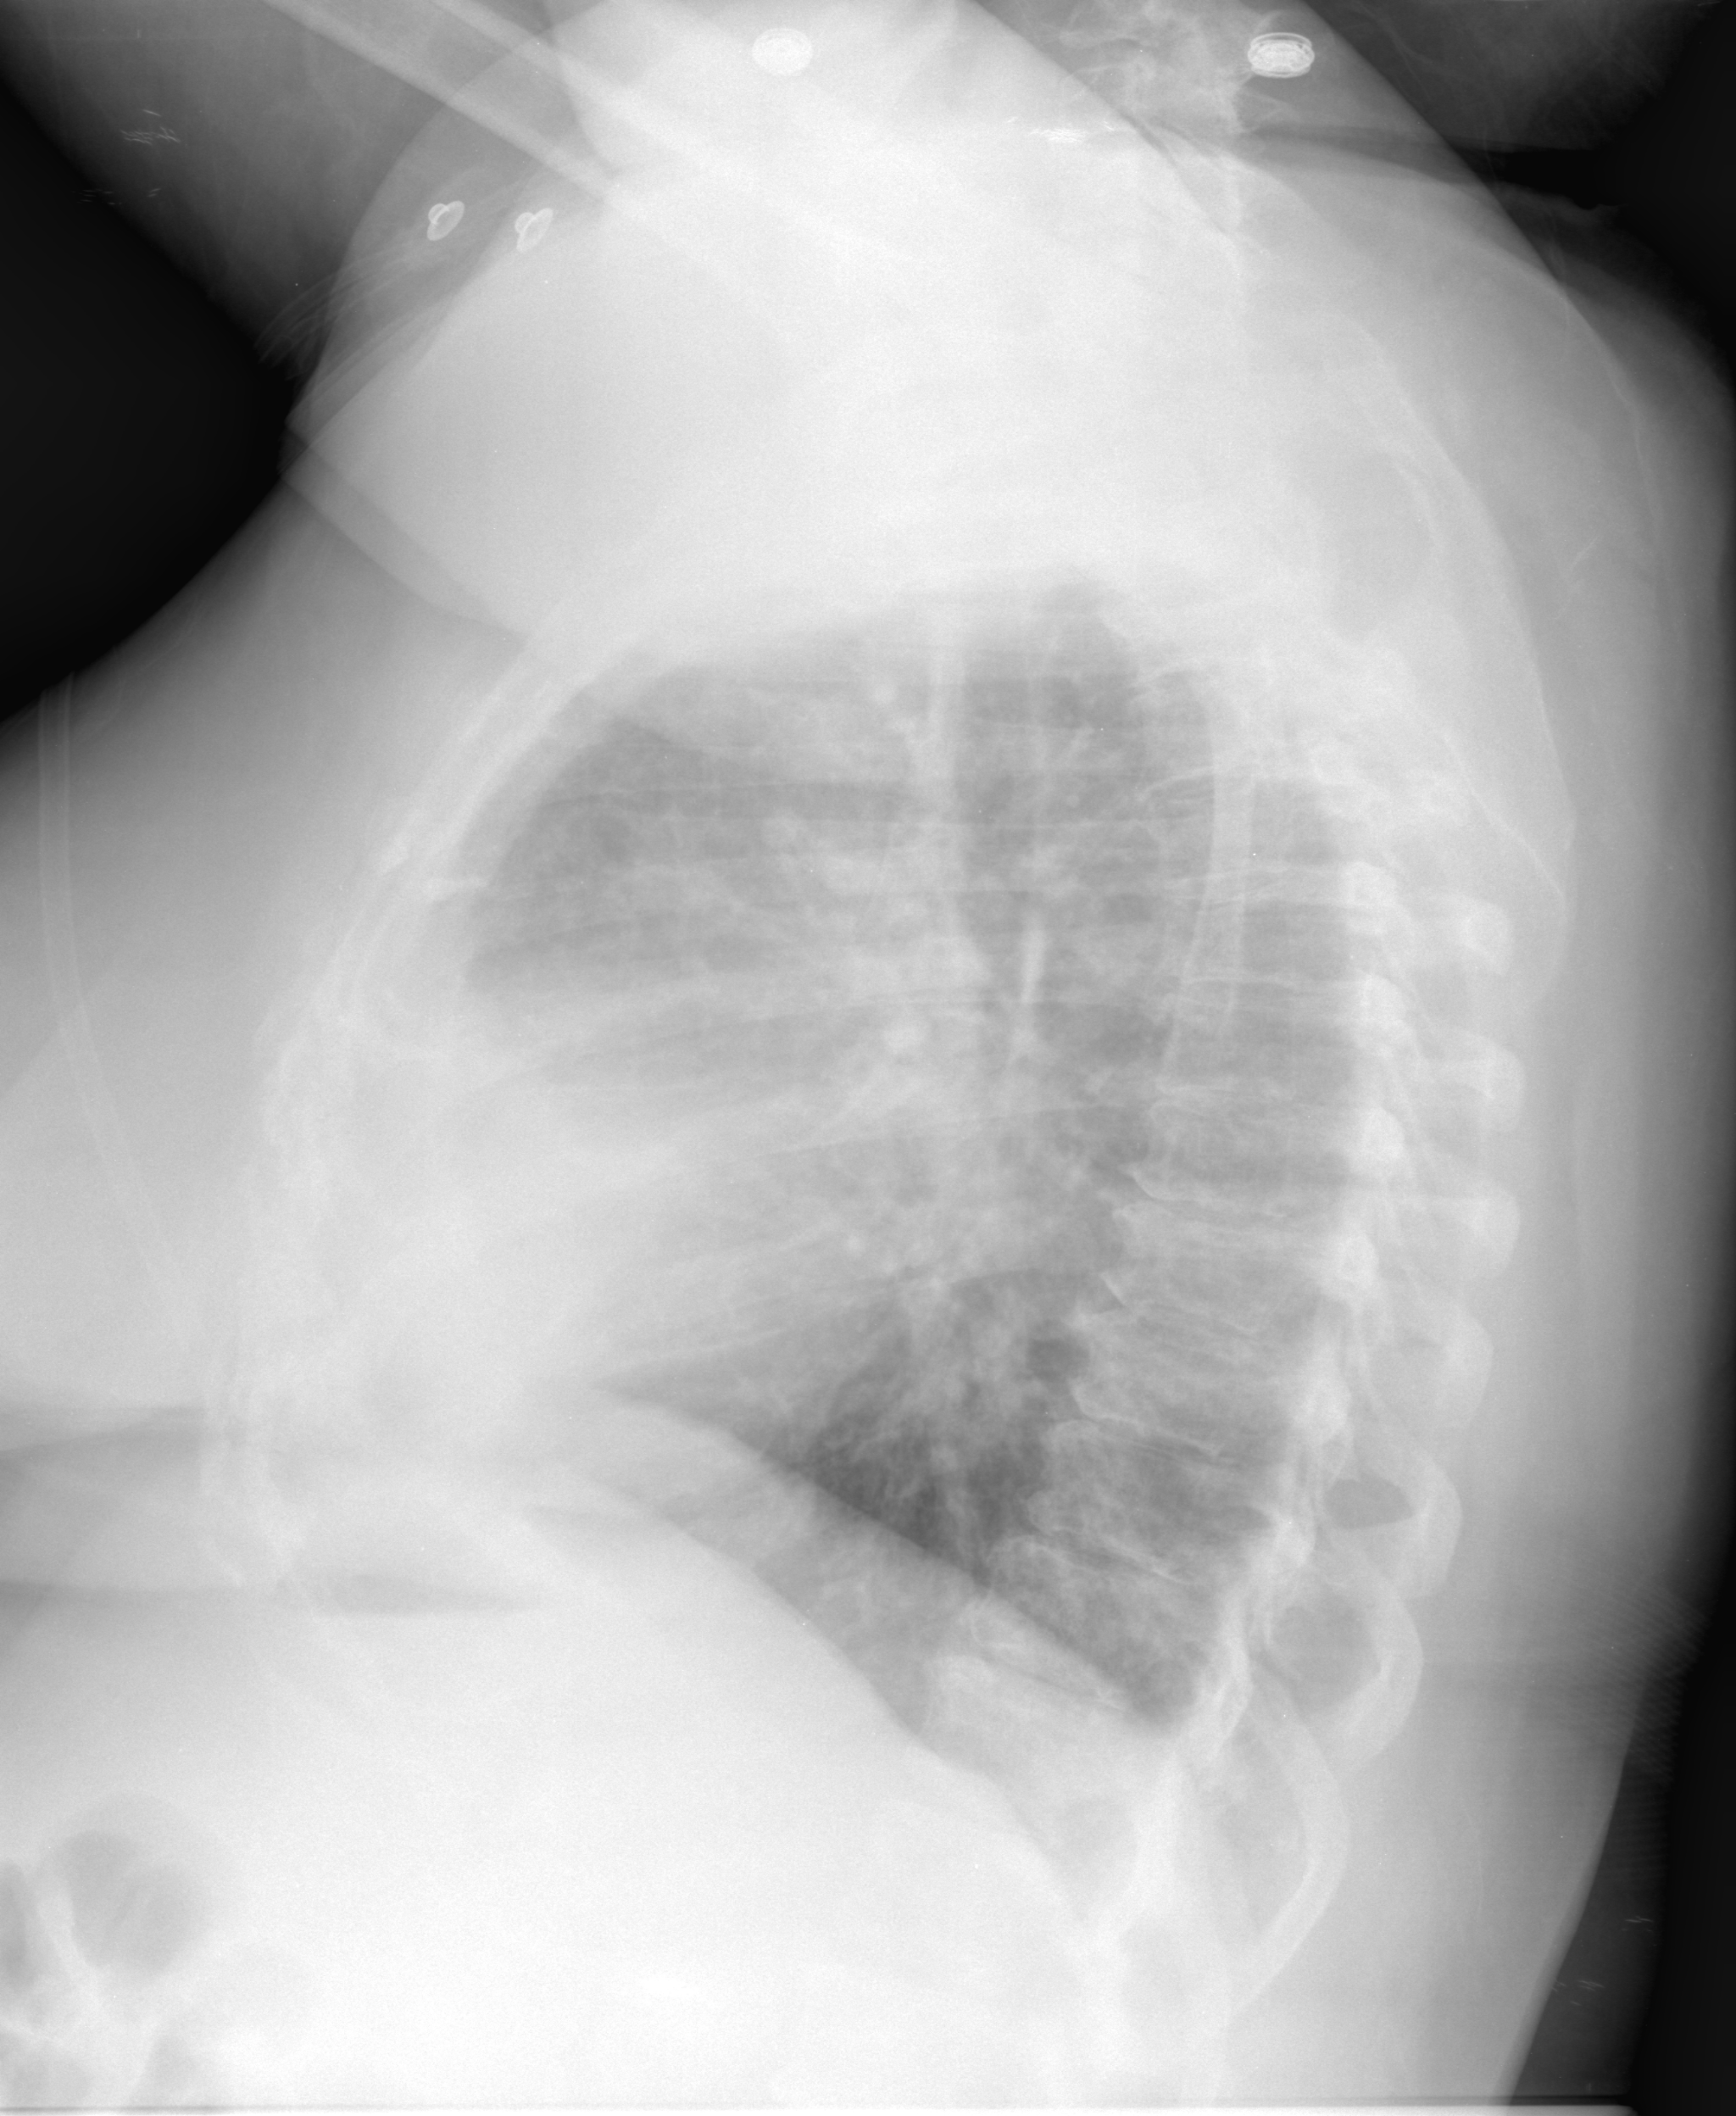

In [ ]:
from IPython.display import display, HTML

# Open and display the generated HTML
with open("report.html", "r") as f:
    html_content = f.read()

# Display HTML in the notebook
display(HTML(html_content))


In [ ]:
from google.colab import files
files.download('report.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>